# Modelling - Training

3 classification models are applied to the training data:
* Multinomial Naive Bayes
* Logistic Regression
* Support Vector Machine (linear kernel)

A pipeline is created for each to cross validate several options and hyper parameters. These include:
* Vectorisation method (CountVectorizer, TfidfTransformer)
* N-gram range (unigrams and bigrams)
* Model specific hyperparameters

5-fold cross-validation is performed for each and F1 accuracy scores obtained. Best parameters and best mean score for each are retained

All machine learning function are provided by the Scikit-Learn library {cite}`sklearn_2011`.

## Load Data

In [265]:
import pandas as pd
import numpy as np

# load data ----
train_df = pd.read_csv('data/train_data_lemma.csv')
#train_df = train_df[train_df['review_text'].str.split().str.len()>=1]
# assign x and y
X_train = train_df.drop(columns = ['classification'])
y_train = train_df[['classification']]
# flatten y
y_train = y_train.values.ravel()
# encode variables (minority class = 1)
y_train = np.where(y_train=='Negative', 1, 0)

## Logistic Regression

In [266]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("lr", LogisticRegression(random_state = 1, max_iter=500)),
    ]
)

parameters = {
    "vect__ngram_range": ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    "lr__C": (0.001, 0.01, 0.1, 1, 10),
}

lr_grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=0, scoring='f1')
lr_grid.fit(X_train.review_text, y_train)

print("Best score: %0.3f" % lr_grid.best_score_)
print("Best parameters:")
print(lr_grid.best_params_)

Best score: 0.838
Best parameters:
{'lr__C': 10, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


## Naive Bayes

In [267]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("nb", MultinomialNB())
    ]
)

parameters = {
    "vect__ngram_range": ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    "nb__alpha": (0.001, 0.01, 0.1, 1, 10)
}

nb_grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=0, scoring='f1')
nb_grid.fit(X_train.review_text, y_train)

print("Best score: %0.3f" % nb_grid.best_score_)
print("Best parameters:")
print(nb_grid.best_params_)

Best score: 0.838
Best parameters:
{'nb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


## Support Vector Machine (linear kernel)

In [268]:
from sklearn.svm import SVC

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("svm", SVC(random_state = 1, kernel = 'linear'))
    ]
)

parameters = {
    "vect__ngram_range": ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
     "svm__C": (0.001, 0.01, 0.1, 1, 10)
}

svm_grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=0, scoring='f1')
svm_grid.fit(X_train.review_text, y_train)

print("Best score: %0.3f" % svm_grid.best_score_)
print("Best parameters:")
print(svm_grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score: 0.841
Best parameters:
{'svm__C': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


## Summary
Accuracy scores are very similar for the best performing parameters of each model.

Results are so close that each model will be applied to the test data for comparison.

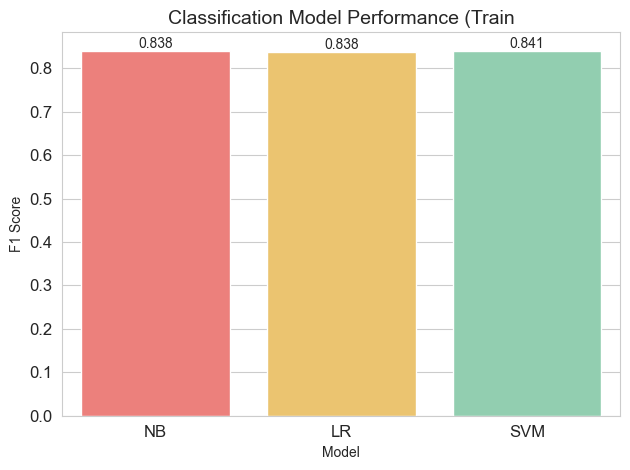

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot model performance
sns.set_style('whitegrid')
ax = sns.barplot(
    data=pd.DataFrame([['NB', nb_grid.best_score_], ['LR', lr_grid.best_score_], ['SVM', svm_grid.best_score_]],columns=['Model','F1 Score']),
    x="Model",
    y='F1 Score',
    palette=["#FF6F69","#ffcc5c","#88D8B0"])

ax.bar_label(ax.containers[0],fmt='%.3f')
plt.title('Classification Model Performance (Train',fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show();


### Store Trained Models

In [270]:
# store trained models
import pickle
pickle.dump(nb_grid.best_estimator_, open("data/nb_trained.sav", 'wb'))
pickle.dump(lr_grid.best_estimator_, open("data/lr_trained.sav", 'wb'))
pickle.dump(svm_grid.best_estimator_, open("data/svm_trained.sav", 'wb'))